In [ ]:
# IMPORT LIBRARY
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# KAGGLE AUTH + DOWNLOAD DATASET

from google.colab import files
import os

uploaded = files.upload()

kaggle_file = list(uploaded.keys())[0]

os.makedirs("/root/.kaggle", exist_ok=True)

os.rename(kaggle_file, "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

!kaggle --version

!kaggle datasets download -d mashlyn/online-retail-ii-uci

!unzip -o online-retail-ii-uci.zip

!ls

In [2]:
# DATA LOADING, COLUMN STANDARDIZATION & INITIAL AUDIT

import pandas as pd
import numpy as np

df = pd.read_csv("dataset/online_retail_II.csv")

df = df.rename(columns={
    "Invoice": "InvoiceNo",
    "Price": "UnitPrice",
    "Customer ID": "CustomerID"
})

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

print(" Dataset Shape :", df.shape)
display(df.head())

print("\n Data Info")
df.info()

missing_summary = (
    df.isna()
    .sum()
    .to_frame(name="missing_count")
    .assign(missing_percent=lambda x: 100 * x.missing_count / len(df))
    .query("missing_count > 0")
)

print("\n Missing Values Summary")
display(missing_summary)

print("\n Transaction Sanity Check")
print("Negative Quantity :", (df["Quantity"] <= 0).sum())
print("Negative UnitPrice :", (df["UnitPrice"] <= 0).sum())
print("Missing CustomerID :", df["CustomerID"].isna().sum())

 Dataset Shape : (1067371, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom



 Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   InvoiceNo    1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   UnitPrice    1067371 non-null  float64       
 6   CustomerID   824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB

 Missing Values Summary


,missing_count,missing_percent
Description,4382,0.410541
CustomerID,243007,22.766873



 Transaction Sanity Check
Negative Quantity : 22950
Negative UnitPrice : 6207
Missing CustomerID : 243007


In [3]:
# DATA CLEANING FOR RFM ANALYSIS

df_clean = df[df["Country"] == "United Kingdom"].copy()

print("After country filter (UK):", df_clean.shape)

df_clean = df_clean.dropna(subset=["CustomerID"])

print("After dropping missing CustomerID:", df_clean.shape)

df_clean = df_clean[
    (df_clean["Quantity"] > 0) &
    (df_clean["UnitPrice"] > 0)
]

print("After removing invalid transactions:", df_clean.shape)

df_clean["Revenue"] = df_clean["Quantity"] * df_clean["UnitPrice"]

print("\nFinal Sanity Check")
print("Negative Quantity :", (df_clean["Quantity"] <= 0).sum())
print("Negative UnitPrice :", (df_clean["UnitPrice"] <= 0).sum())
print("Missing CustomerID :", df_clean["CustomerID"].isna().sum())

display(df_clean.head())

After country filter (UK): (981330, 8)
After dropping missing CustomerID: (741301, 8)
After removing invalid transactions: (725250, 8)

Final Sanity Check
Negative Quantity : 0
Negative UnitPrice : 0
Missing CustomerID : 0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [4]:
# RFM FEATURE ENGINEERING

snapshot_date = df_clean["InvoiceDate"].max() + pd.Timedelta(days=1)

print("Snapshot Date:", snapshot_date)

rfm = (
    df_clean
    .groupby("CustomerID")
    .agg({
        "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency
        "InvoiceNo": "nunique",                                    # Frequency
        "Revenue": "sum"                                           # Monetary
    })
    .reset_index()
)

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

print("RFM Shape:", rfm.shape)
display(rfm.head())

print("\nRFM Summary Statistics")
display(rfm.describe())

Snapshot Date: 2011-12-10 12:49:00
RFM Shape: (5350, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,12,77556.46
1,12608.0,405,1,415.79
2,12745.0,487,2,723.85
3,12746.0,541,1,254.55
4,12747.0,2,26,9276.54



RFM Summary Statistics


,CustomerID,Recency,Frequency,Monetary
count,5350.000000,5350.000000,5350.000000,5350.000000
mean,15557.362617,203.000935,6.269346,2751.990190
std,1581.161762,209.959231,11.995550,12080.466564
min,12346.000000,1.000000,1.000000,2.950000
25%,14191.250000,26.000000,1.000000,336.167500
50%,15565.500000,98.500000,3.000000,849.910000
75%,16922.750000,382.000000,7.000000,2214.905000
max,18287.000000,739.000000,336.000000,608821.650000


In [5]:
# RFM SCORE CLASSIC (QUANTILE-BASED BASELINE)

rfm_score = rfm.copy()

# quantile binning (1–5)
rfm_score["R_Score"] = pd.qcut(
    rfm_score["Recency"],
    5,
    labels=[5, 4, 3, 2, 1]
).astype(int)

rfm_score["F_Score"] = pd.qcut(
    rfm_score["Frequency"].rank(method="first"),
    5,
    labels=[1, 2, 3, 4, 5]
).astype(int)

rfm_score["M_Score"] = pd.qcut(
    rfm_score["Monetary"].rank(method="first"),
    5,
    labels=[1, 2, 3, 4, 5]
).astype(int)

# combined RFM score
rfm_score["RFM_Score"] = (
    rfm_score["R_Score"] +
    rfm_score["F_Score"] +
    rfm_score["M_Score"]
)

# classic segment mapping
def map_classic_rfm_segment(row):
    if row["R_Score"] >= 4 and row["F_Score"] >= 4 and row["M_Score"] >= 4:
        return "Champions"
    if row["F_Score"] >= 4 and row["M_Score"] >= 3:
        return "Loyal Customers"
    if row["R_Score"] >= 4 and row["F_Score"] >= 2:
        return "Potential Loyalists"
    if row["R_Score"] <= 2 and row["F_Score"] <= 2:
        return "At Risk"
    return "Others"

rfm_score["Classic_Segment"] = rfm_score.apply(
    map_classic_rfm_segment,
    axis=1
)

print(" CLASSIC RFM SCORE SUMMARY")
display(
    rfm_score[["R_Score", "F_Score", "M_Score", "RFM_Score"]]
    .describe()
    .round(2)
)

print(" CLASSIC RFM SEGMENT DISTRIBUTION")
display(
    rfm_score["Classic_Segment"]
    .value_counts()
    .rename("Total_Customers")
    .to_frame()
)

print(" CLASSIC RFM SEGMENT PROFILE (MEAN RFM)")
display(
    rfm_score
    .groupby("Classic_Segment")[["Recency", "Frequency", "Monetary"]]
    .mean()
    .round(2)
)

# integrity check
assert rfm_score.shape[0] == rfm.shape[0]
print(" Classic RFM baseline ready")

 CLASSIC RFM SCORE SUMMARY


,R_Score,F_Score,M_Score,RFM_Score
count,5350.00,5350.00,5350.00,5350.00
mean,3.01,3.00,3.00,9.01
std,1.42,1.41,1.41,3.66
min,1.00,1.00,1.00,3.00
25%,2.00,2.00,2.00,6.00
50%,3.00,3.00,3.00,9.00
75%,4.00,4.00,4.00,12.00
max,5.00,5.00,5.00,15.00


 CLASSIC RFM SEGMENT DISTRIBUTION


,Total_Customers
Classic_Segment,
At Risk,1393
Others,1206
Champions,1193
Loyal Customers,882
Potential Loyalists,676


 CLASSIC RFM SEGMENT PROFILE (MEAN RFM)


,Recency,Frequency,Monetary
Classic_Segment,,,
At Risk,461.64,1.25,395.23
Champions,20.28,16.81,8281.91
Loyal Customers,172.88,7.99,2940.92
Others,206.19,2.39,814.64
Potential Loyalists,26.12,2.68,1059.08


 Classic RFM baseline ready


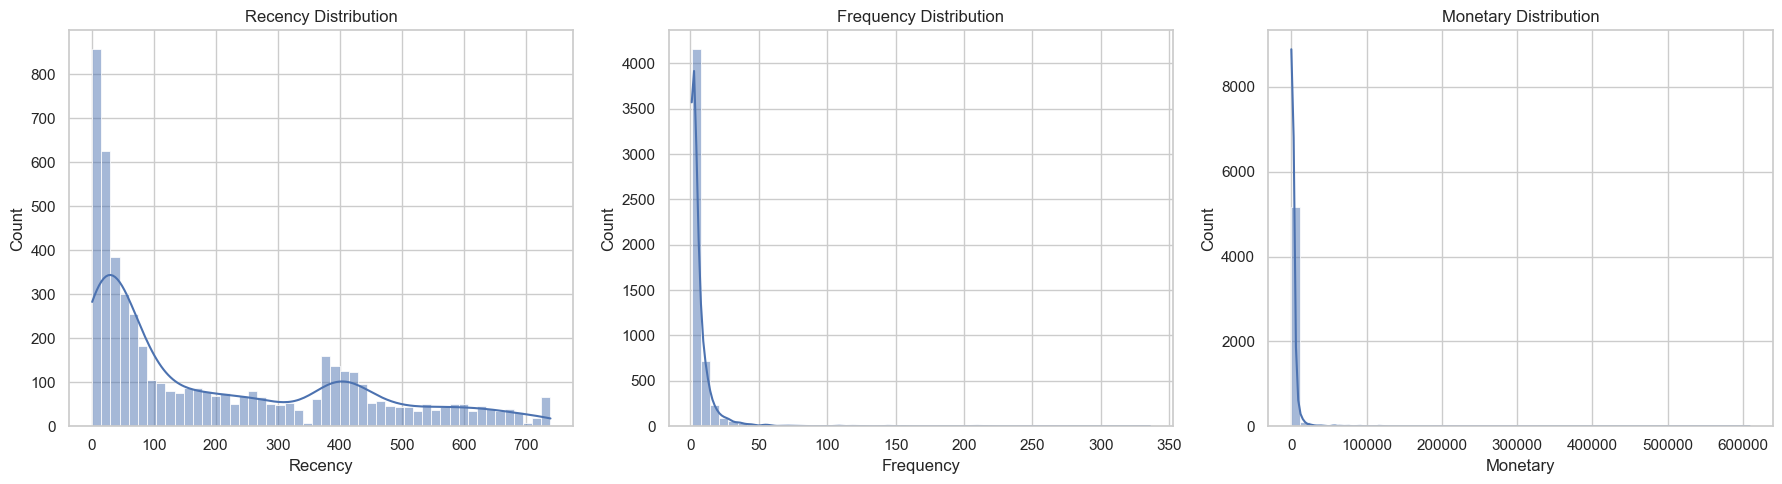

  Skewness Values


Recency       0.872034
Frequency    10.433090
Monetary     28.971352
dtype: float64

In [6]:
# RFM DISTRIBUTION & SKEWNESS ANALYSIS

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm["Recency"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Recency Distribution")

sns.histplot(rfm["Frequency"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Frequency Distribution")

sns.histplot(rfm["Monetary"], bins=50, kde=True, ax=axes[2])
axes[2].set_title("Monetary Distribution")

plt.tight_layout()
plt.savefig("output/01_rfm_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

skewness = rfm[["Recency", "Frequency", "Monetary"]].skew()

print("  Skewness Values")
display(skewness)

In [7]:
# LOG TRANSFORMATION & FEATURE SCALING

import numpy as np
from sklearn.preprocessing import StandardScaler

rfm_transformed = rfm.copy()

rfm_transformed["Recency_log"]   = np.log1p(rfm_transformed["Recency"])
rfm_transformed["Frequency_log"] = np.log1p(rfm_transformed["Frequency"])
rfm_transformed["Monetary_log"]  = np.log1p(rfm_transformed["Monetary"])

rfm_features = rfm_transformed[
    ["Recency_log", "Frequency_log", "Monetary_log"]
]

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

rfm_scaled_df = (
    pd.DataFrame(
        rfm_scaled,
        columns=["Recency_scaled", "Frequency_scaled", "Monetary_scaled"],
        index=rfm_transformed["CustomerID"]
    )
)

print(" Scaled Feature Statistics (mean ≈ 0, std ≈ 1)")
display(rfm_scaled_df.describe().round(4))

rfm_scaled_df.head()

 Scaled Feature Statistics (mean ≈ 0, std ≈ 1)


,Recency_scaled,Frequency_scaled,Monetary_scaled
count,5350.0000,5350.0000,5350.0000
mean,-0.0000,0.0000,0.0000
std,1.0001,1.0001,1.0001
min,-2.4149,-1.0627,-3.9389
25%,-0.7480,-1.0627,-0.7087
50%,0.0873,-0.2073,-0.0363
75%,0.9505,0.6480,0.6589
max,1.3723,5.2641,4.7382


,Recency_scaled,Frequency_scaled,Monetary_scaled
CustomerID,,,
12346.0,0.849312,1.247157,3.241473
12608.0,0.987897,-1.062694,-0.554736
12745.0,1.105713,-0.562340,-0.152769
12746.0,1.172926,-1.062694,-0.910056
12747.0,-2.155180,2.149091,1.699058


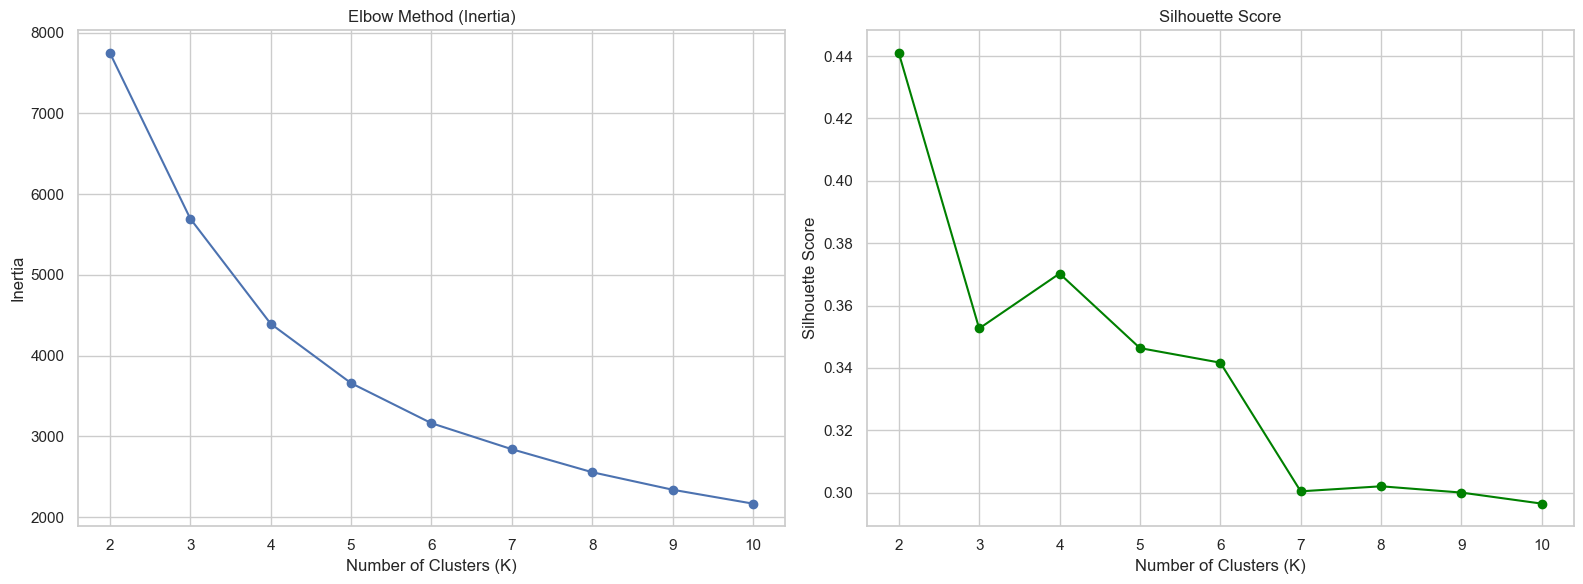

,K,Inertia,SilhouetteScore
0,2,7748.352223,0.440990
1,3,5696.558640,0.352630
2,4,4395.361381,0.370245
3,5,3659.922868,0.346346
4,6,3163.912606,0.341664
5,7,2841.875653,0.300412
6,8,2556.898025,0.302026
7,9,2340.079205,0.300010
8,10,2167.862578,0.296463


In [8]:
# ELBOW METHOD & SILHOUETTE SCORE (OPTIMAL K SELECTION)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

k_range = range(2, 11)

inertia_values = []
silhouette_values = []

for k in k_range:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    cluster_labels = kmeans.fit_predict(rfm_scaled_df)

    inertia_values.append(kmeans.inertia_)
    silhouette_values.append(
        silhouette_score(rfm_scaled_df, cluster_labels)
    )

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(k_range, inertia_values, marker='o')
ax[0].set_title("Elbow Method (Inertia)")
ax[0].set_xlabel("Number of Clusters (K)")
ax[0].set_ylabel("Inertia")
ax[0].grid(True)

ax[1].plot(k_range, silhouette_values, marker='o', color='green')
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("Number of Clusters (K)")
ax[1].set_ylabel("Silhouette Score")
ax[1].grid(True)

plt.tight_layout()
plt.savefig("output/02_elbow_silhouette_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

silhouette_summary = pd.DataFrame({
    "K": list(k_range),
    "Inertia": inertia_values,
    "SilhouetteScore": silhouette_values
})

display(silhouette_summary)

 K-MEANS STABILITY CHECK — RAW RESULTS


,RandomState,SilhouetteScore,Inertia
0,10,0.3702,4395.3585
1,15,0.3702,4395.3508
2,20,0.3703,4395.3511
3,25,0.3702,4395.3665
4,30,0.3704,4395.3725
5,35,0.3703,4395.3649
6,40,0.3702,4395.4156
7,45,0.3703,4395.3445
8,50,0.3702,4395.3700
9,55,0.3704,4395.3749


 K-MEANS STABILITY SUMMARY


,Value
Metric,
Silhouette_Mean,0.370287
Silhouette_Std,0.000056
Silhouette_Min,0.370220
Silhouette_Max,0.370373
Inertia_Mean,4395.366930
Inertia_Std,0.019892
Silhouette_CV,0.000151


 STABILITY ASSESSMENT: Cluster solution is STABLE across random states.


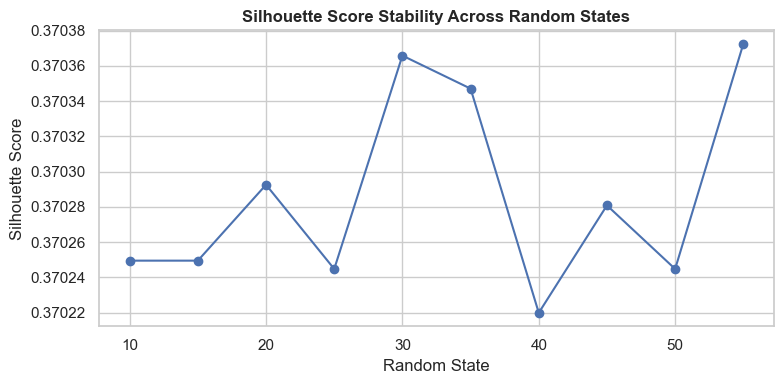

 Stability check completed successfully


In [9]:
# K-MEANS STABILITY CHECK (RANDOM STATE SENSITIVITY ANALYSIS)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

OPTIMAL_K = 4
RANDOM_STATES = range(10, 60, 5)

results = []

for seed in RANDOM_STATES:
    kmeans = KMeans(
        n_clusters=OPTIMAL_K,
        random_state=seed,
        n_init=10
    )

    labels = kmeans.fit_predict(rfm_scaled_df)

    results.append({
        "RandomState": seed,
        "SilhouetteScore": silhouette_score(rfm_scaled_df, labels),
        "Inertia": kmeans.inertia_
    })

stability_df = pd.DataFrame(results)

print(" K-MEANS STABILITY CHECK — RAW RESULTS")
display(stability_df.round(4))


# summary statistics (explicit & safe)
sil_mean = stability_df["SilhouetteScore"].mean()
sil_std  = stability_df["SilhouetteScore"].std()
sil_min  = stability_df["SilhouetteScore"].min()
sil_max  = stability_df["SilhouetteScore"].max()

inertia_mean = stability_df["Inertia"].mean()
inertia_std  = stability_df["Inertia"].std()

stability_summary = pd.DataFrame({
    "Metric": [
        "Silhouette_Mean",
        "Silhouette_Std",
        "Silhouette_Min",
        "Silhouette_Max",
        "Inertia_Mean",
        "Inertia_Std"
    ],
    "Value": [
        sil_mean,
        sil_std,
        sil_min,
        sil_max,
        inertia_mean,
        inertia_std
    ]
}).set_index("Metric").round(6)

# coefficient of variation (stability indicator)
stability_summary.loc["Silhouette_CV"] = round(sil_std / sil_mean, 6)

print(" K-MEANS STABILITY SUMMARY")
display(stability_summary)


# stability interpretation
STABILITY_THRESHOLD = 0.10

if stability_summary.loc["Silhouette_CV", "Value"] < STABILITY_THRESHOLD:
    print(" STABILITY ASSESSMENT: Cluster solution is STABLE across random states.")
else:
    print(" STABILITY ASSESSMENT: Cluster solution shows sensitivity to initialization.")


# visualization
plt.figure(figsize=(8, 4))
plt.plot(
    stability_df["RandomState"],
    stability_df["SilhouetteScore"],
    marker="o"
)
plt.title("Silhouette Score Stability Across Random States", weight="bold")
plt.xlabel("Random State")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.savefig("output/03_kmeans_stability.png", dpi=300, bbox_inches='tight')
plt.show()


# integrity checks
assert stability_df.shape[0] == len(RANDOM_STATES)
assert sil_std < 0.01

print(" Stability check completed successfully")

 FINAL K-MEANS METRICS
Number of clusters : 4
Silhouette Score   : 0.3702
Inertia            : 4395.36

 K-MEANS ROBUSTNESS CHECK


,RandomState,SilhouetteScore,Inertia
0,10,0.3702,4395.3585
1,15,0.3702,4395.3508
2,20,0.3703,4395.3511
3,25,0.3702,4395.3665
4,30,0.3704,4395.3725
5,35,0.3703,4395.3649
6,40,0.3702,4395.4156
7,45,0.3703,4395.3445
8,50,0.3702,4395.3700
9,55,0.3704,4395.3749



 K-MEANS STABILITY SUMMARY


,Metric,Value
0,Silhouette_Mean,0.370287
1,Silhouette_Std,0.000056
2,Silhouette_CV,0.000151


 STABILITY ASSESSMENT: K-Means clustering is STABLE across random states.


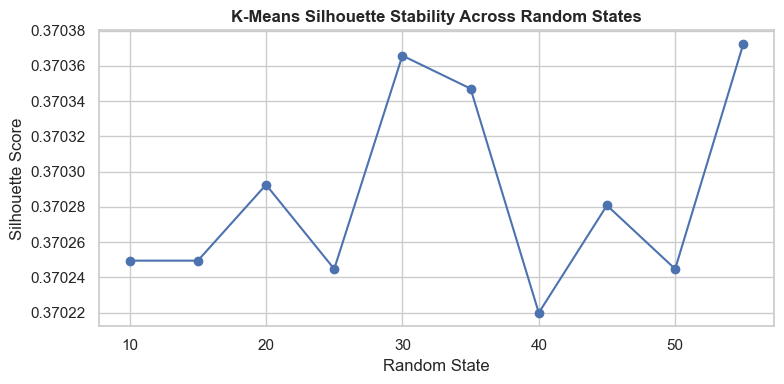

 METHOD JUSTIFICATION

K-Means dipilih sebagai satu-satunya metode clustering karena:
1. Memberikan segmentasi yang stabil terhadap inisialisasi centroid.
2. Menghasilkan jumlah cluster yang jelas dan dapat diinterpretasikan secara bisnis.
3. Cocok untuk data RFM retail yang bersifat kontinyu dan saling overlap.
4. Mendukung kebutuhan utama sistem PROMIND: segmentasi customer untuk strategi pemasaran.

 K-Means validation completed successfully


In [10]:
# K-MEANS ROBUSTNESS & METHOD JUSTIFICATION
# Primary Clustering Method Validation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans_final = KMeans(
    n_clusters=OPTIMAL_K,
    random_state=42,
    n_init=10
)

kmeans_labels = kmeans_final.fit_predict(rfm_scaled_df)

silhouette_final = silhouette_score(rfm_scaled_df, kmeans_labels)
inertia_final = kmeans_final.inertia_

print(" FINAL K-MEANS METRICS")
print(f"Number of clusters : {OPTIMAL_K}")
print(f"Silhouette Score   : {silhouette_final:.4f}")
print(f"Inertia            : {inertia_final:.2f}")

RANDOM_STATES = range(10, 60, 5)

robustness_results = []

for seed in RANDOM_STATES:
    km = KMeans(
        n_clusters=OPTIMAL_K,
        random_state=seed,
        n_init=10
    )
    labels = km.fit_predict(rfm_scaled_df)

    robustness_results.append({
        "RandomState": seed,
        "SilhouetteScore": silhouette_score(rfm_scaled_df, labels),
        "Inertia": km.inertia_
    })

robustness_df = pd.DataFrame(robustness_results)

print("\n K-MEANS ROBUSTNESS CHECK")
display(robustness_df.round(4))

sil_mean = robustness_df["SilhouetteScore"].mean()
sil_std  = robustness_df["SilhouetteScore"].std()
sil_cv   = sil_std / sil_mean

print("\n K-MEANS STABILITY SUMMARY")
display(
    pd.DataFrame({
        "Metric": ["Silhouette_Mean", "Silhouette_Std", "Silhouette_CV"],
        "Value": [sil_mean, sil_std, sil_cv]
    }).round(6)
)

if sil_cv < 0.10:
    print(" STABILITY ASSESSMENT: K-Means clustering is STABLE across random states.")
else:
    print(" STABILITY ASSESSMENT: K-Means shows sensitivity to initialization.")

plt.figure(figsize=(8, 4))
plt.plot(
    robustness_df["RandomState"],
    robustness_df["SilhouetteScore"],
    marker="o"
)
plt.title("K-Means Silhouette Stability Across Random States", weight="bold")
plt.xlabel("Random State")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.savefig("output/09_kmeans_robustness.png", dpi=300, bbox_inches='tight')
plt.show()

print(" METHOD JUSTIFICATION")
print("""
K-Means dipilih sebagai satu-satunya metode clustering karena:
1. Memberikan segmentasi yang stabil terhadap inisialisasi centroid.
2. Menghasilkan jumlah cluster yang jelas dan dapat diinterpretasikan secara bisnis.
3. Cocok untuk data RFM retail yang bersifat kontinyu dan saling overlap.
4. Mendukung kebutuhan utama sistem PROMIND: segmentasi customer untuk strategi pemasaran.
""")

print(" K-Means validation completed successfully")

In [12]:
# CREATE RFM_RESULT WITH CLUSTER LABELS

# Attach cluster labels to original RFM data
rfm_result = rfm.copy()
rfm_result["Cluster"] = kmeans_labels

# Cluster distribution
cluster_distribution = (
    rfm_result["Cluster"]
    .value_counts()
    .sort_index()
    .rename("Total_Customers")
    .to_frame()
)

print(" CLUSTER DISTRIBUTION")
display(cluster_distribution)

# Complete cluster profile
cluster_profile_full = (
    rfm_result
    .groupby("Cluster")[["Recency", "Frequency", "Monetary"]]
    .agg(
        Customers=("Recency", "count"),
        Recency_Mean=("Recency", "mean"),
        Recency_Min=("Recency", "min"),
        Recency_Max=("Recency", "max"),
        Recency_Median=("Recency", "median"),
        Recency_Std=("Recency", "std"),
        Frequency_Mean=("Frequency", "mean"),
        Frequency_Min=("Frequency", "min"),
        Frequency_Max=("Frequency", "max"),
        Frequency_Median=("Frequency", "median"),
        Frequency_Std=("Frequency", "std"),
        Monetary_Mean=("Monetary", "mean"),
        Monetary_Min=("Monetary", "min"),
        Monetary_Max=("Monetary", "max"),
        Monetary_Median=("Monetary", "median"),
        Monetary_Std=("Monetary", "std")
    )
    .round(2)
)

print(" COMPLETE CLUSTER PROFILE — FULL DESCRIPTIVE STATISTICS")
display(cluster_profile_full)

# Executive summary view
cluster_profile_exec = (
    rfm_result
    .groupby("Cluster")[["Recency", "Frequency", "Monetary"]]
    .describe()
    .loc[:, (slice(None), ["mean", "min", "max"])]
    .round(2)
)

print(" EXECUTIVE CLUSTER PROFILE (MEAN / MIN / MAX)")
display(cluster_profile_exec)

# Data integrity check
assert rfm_result.shape[0] == rfm.shape[0]
assert "Cluster" in rfm_result.columns

print(" Data integrity check passed")

 CLUSTER DISTRIBUTION


,Total_Customers
Cluster,
0,1133
1,1831
2,1320
3,1066


 COMPLETE CLUSTER PROFILE — FULL DESCRIPTIVE STATISTICS


,Customers,Recency_Mean,Recency_Min,Recency_Max,Recency_Median,Recency_Std,Frequency_Mean,Frequency_Min,Frequency_Max,Frequency_Median,Frequency_Std,Monetary_Mean,Monetary_Min,Monetary_Max,Monetary_Median,Monetary_Std
Cluster,,,,,,,,,,,,,,,,
0,1133,28.42,1,99,24.0,20.79,3.09,1,14,3.0,1.66,845.12,43.20,4014.10,735.17,574.43
1,1831,395.32,23,739,403.0,188.95,1.38,1,8,1.0,0.65,316.59,2.95,1680.47,271.70,221.56
2,1320,228.07,31,738,184.5,156.09,5.24,1,20,5.0,2.66,1909.93,167.42,44534.30,1468.82,2145.21
3,1066,27.18,1,497,16.0,41.08,19.32,2,336,13.0,22.06,10004.54,862.42,608821.65,5023.34,25675.85


 EXECUTIVE CLUSTER PROFILE (MEAN / MIN / MAX)


Recency              Frequency              Monetary          \
           mean   min    max      mean  min    max      mean     min   
Cluster                                                                
0         28.42   1.0   99.0      3.09  1.0   14.0    845.12   43.20   
1        395.32  23.0  739.0      1.38  1.0    8.0    316.59    2.95   
2        228.07  31.0  738.0      5.24  1.0   20.0   1909.93  167.42   
3         27.18   1.0  497.0     19.32  2.0  336.0  10004.54  862.42   

                    
               max  
Cluster             
0          4014.10  
1          1680.47  
2         44534.30  
3        608821.65

 Data integrity check passed


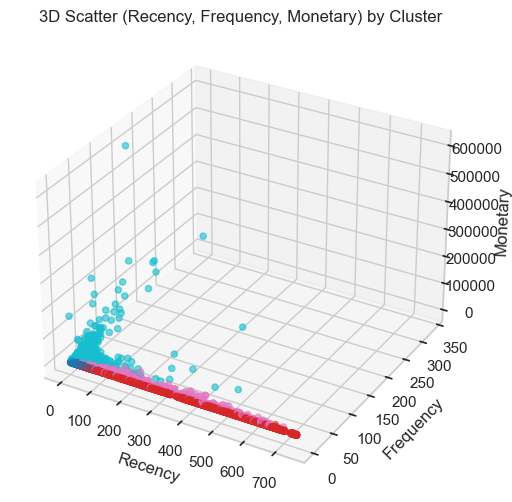

In [13]:
# 3D VISUALISASI RFM (Plotly interaktif + Matplotlib 3D sebagai fallback)
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

# Siapkan data untuk visualisasi
df3 = rfm_result.copy()
df3['Recency_log'] = np.log1p(df3['Recency'])
df3['Frequency_log'] = np.log1p(df3['Frequency'])
df3['Monetary_log'] = np.log1p(df3['Monetary'])

# Plotly 3D scatter - berdasarkan Cluster
try:
    fig = px.scatter_3d(df3, x='Recency', y='Frequency', z='Monetary', color='Cluster', hover_data=['CustomerID'],
                        title='3D: Recency vs Frequency vs Monetary (by Cluster)')
    fig.update_layout(width=900, height=700)
    fig.show()
except Exception as e:
    print('Plotly 3D failed:', e)

# Plotly 3D colored by Segment jika tersedia
if 'Segment' in df3.columns:
    try:
        fig2 = px.scatter_3d(df3, x='Recency', y='Frequency', z='Monetary', color='Segment', hover_data=['CustomerID'],
                         title='3D: RFM by Segment')
        fig2.update_layout(width=900, height=700)
        fig2.show()
    except Exception as e:
        print('Plotly 3D (Segment) failed:', e)

# Matplotlib 3D sebagai fallback statis
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df3['Recency'], df3['Frequency'], df3['Monetary'], c=df3['Cluster'], cmap='tab10', alpha=0.6)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Scatter (Recency, Frequency, Monetary) by Cluster')
plt.savefig("output/04_3d_rfm_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# CLUSTER INTERPRETATION & BUSINESS SEGMENT NAMING

# ringkasan mean RFM per cluster (sumber utama interpretasi)
cluster_profile = (
    rfm_result
    .groupby("Cluster")[["Recency", "Frequency", "Monetary"]]
    .mean()
)

# ranking RFM (Recency kecil = lebih baik)
segment_profile = cluster_profile.copy()

segment_profile["Recency_rank"] = segment_profile["Recency"].rank(ascending=True)
segment_profile["Frequency_rank"] = segment_profile["Frequency"].rank(ascending=False)
segment_profile["Monetary_rank"] = segment_profile["Monetary"].rank(ascending=False)

# skor total untuk penentuan urutan segmen
segment_profile["Overall_rank"] = (
    segment_profile["Recency_rank"]
    + segment_profile["Frequency_rank"]
    + segment_profile["Monetary_rank"]
)

segment_profile = segment_profile.sort_values("Overall_rank")

print(" CLUSTER RANKING (BASIS PENAMAAN SEGMENT)")
display(segment_profile)

# mapping cluster ke nama segmen bisnis
segment_name_map = {
    segment_profile.index[0]: "Champions",
    segment_profile.index[1]: "Loyal Customers",
    segment_profile.index[2]: "Potential Loyalists",
    segment_profile.index[3]: "At Risk"
}

rfm_result["Segment"] = rfm_result["Cluster"].map(segment_name_map)

print(" DISTRIBUSI SEGMENT")
display(
    rfm_result["Segment"]
    .value_counts()
    .rename("Total_Customers")
    .to_frame()
)

print(" RINGKASAN RFM PER SEGMENT (MEAN)")
display(
    rfm_result
    .groupby("Segment")[["Recency", "Frequency", "Monetary"]]
    .mean()
    .round(2)
)

# integrity check
assert rfm_result["Segment"].isna().sum() == 0
print(" Segment naming completed successfully")

rfm_result.head()

 CLUSTER RANKING (BASIS PENAMAAN SEGMENT)


,Recency,Frequency,Monetary,Recency_rank,Frequency_rank,Monetary_rank,Overall_rank
Cluster,,,,,,,
3,27.177298,19.317073,10004.543431,1.0,1.0,1.0,3.0
2,228.065909,5.243182,1909.929786,3.0,2.0,2.0,7.0
0,28.419241,3.087379,845.121017,2.0,3.0,3.0,8.0
1,395.323867,1.381759,316.589181,4.0,4.0,4.0,12.0


 DISTRIBUSI SEGMENT


,Total_Customers
Segment,
At Risk,1831
Loyal Customers,1320
Potential Loyalists,1133
Champions,1066


 RINGKASAN RFM PER SEGMENT (MEAN)


,Recency,Frequency,Monetary
Segment,,,
At Risk,395.32,1.38,316.59
Champions,27.18,19.32,10004.54
Loyal Customers,228.07,5.24,1909.93
Potential Loyalists,28.42,3.09,845.12


 Segment naming completed successfully


,CustomerID,Recency,Frequency,Monetary,Cluster,Segment
0,12346.0,326,12,77556.46,3,Champions
1,12608.0,405,1,415.79,1,At Risk
2,12745.0,487,2,723.85,1,At Risk
3,12746.0,541,1,254.55,1,At Risk
4,12747.0,2,26,9276.54,3,Champions


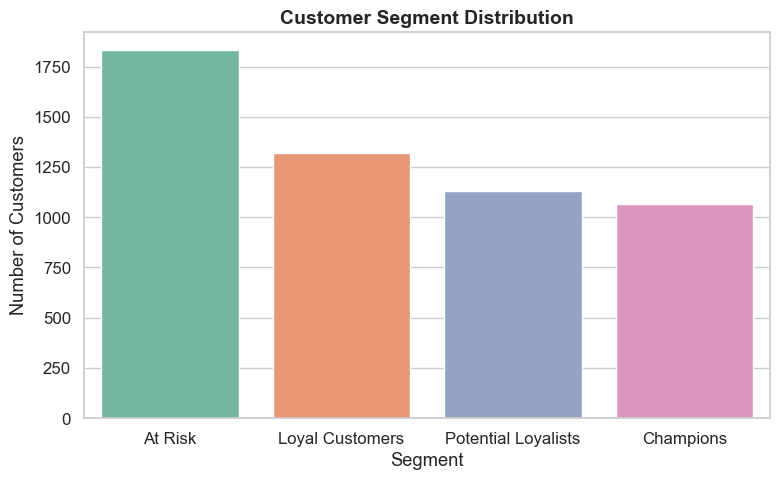

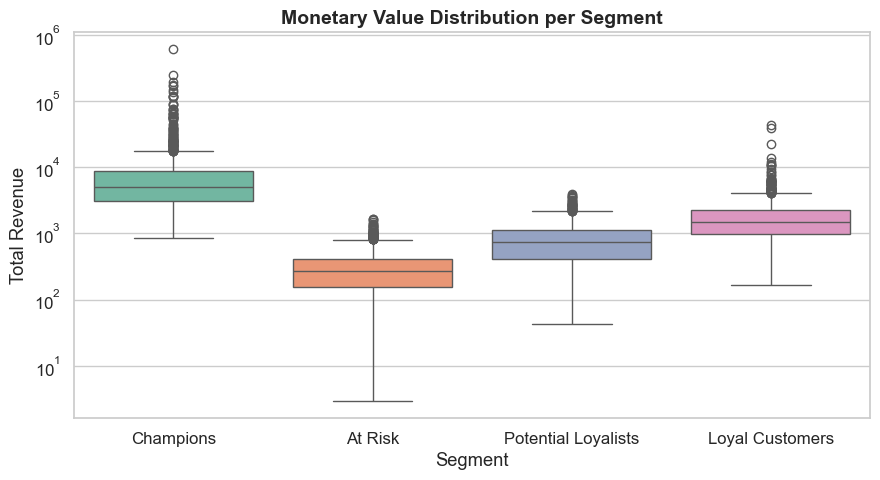

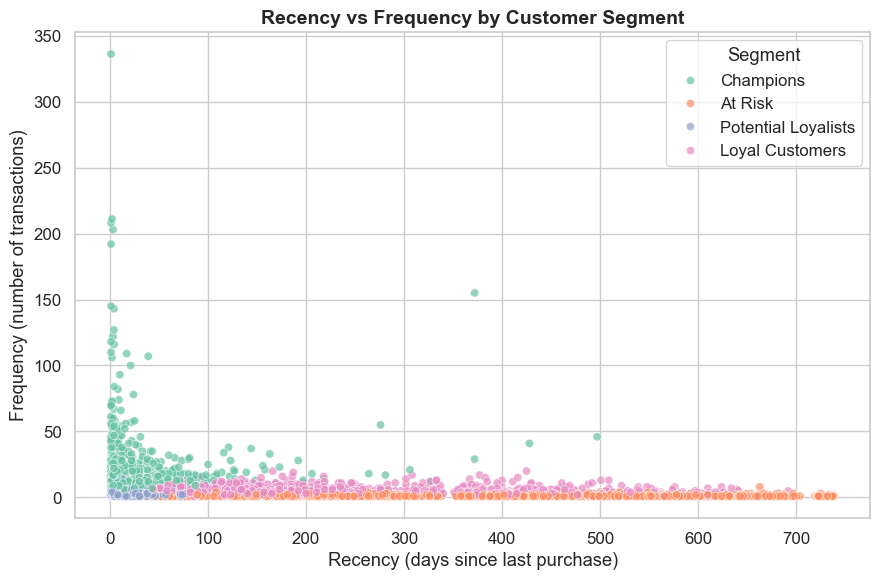

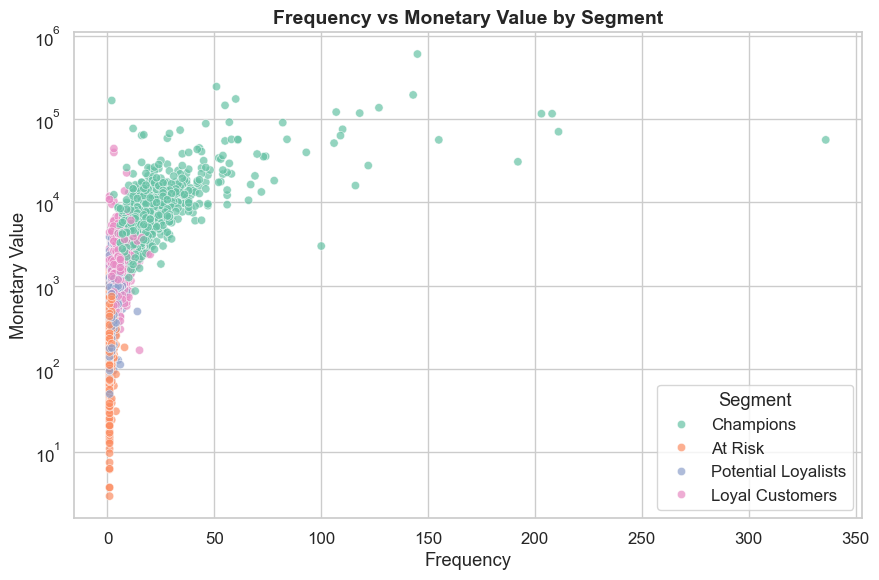

In [15]:
# RFM & SEGMENT VISUALIZATION

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(8,5))
sns.countplot(
    data=rfm_result,
    x="Segment",
    order=rfm_result["Segment"].value_counts().index,
    palette="Set2"
)
plt.title("Customer Segment Distribution", fontsize=14, weight="bold")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.savefig("output/05_segment_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(9,5))
sns.boxplot(
    data=rfm_result,
    x="Segment",
    y="Monetary",
    palette="Set2"
)
plt.title("Monetary Value Distribution per Segment", fontsize=14, weight="bold")
plt.xlabel("Segment")
plt.ylabel("Total Revenue")
plt.yscale("log")
plt.tight_layout()
plt.savefig("output/06_monetary_by_segment.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(9,6))
sns.scatterplot(
    data=rfm_result,
    x="Recency",
    y="Frequency",
    hue="Segment",
    palette="Set2",
    alpha=0.7
)
plt.title("Recency vs Frequency by Customer Segment", fontsize=14, weight="bold")
plt.xlabel("Recency (days since last purchase)")
plt.ylabel("Frequency (number of transactions)")
plt.legend(title="Segment")
plt.tight_layout()
plt.savefig("output/07_recency_vs_frequency.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(9,6))
sns.scatterplot(
    data=rfm_result,
    x="Frequency",
    y="Monetary",
    hue="Segment",
    palette="Set2",
    alpha=0.7
)
plt.title("Frequency vs Monetary Value by Segment", fontsize=14, weight="bold")
plt.xlabel("Frequency")
plt.ylabel("Monetary Value")
plt.yscale("log")
plt.legend(title="Segment")
plt.tight_layout()
plt.savefig("output/08_frequency_vs_monetary.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
import pandas as pd
import numpy as np

insight_df = rfm_result.copy()

TOTAL_CUSTOMERS = insight_df.shape[0]
TOTAL_REVENUE = insight_df["Monetary"].sum()
AVG_REVENUE_PER_CUSTOMER = TOTAL_REVENUE / TOTAL_CUSTOMERS

print(" GLOBAL BUSINESS OVERVIEW")
print(f"Total Customers          : {TOTAL_CUSTOMERS:,}")
print(f"Total Revenue            : £{TOTAL_REVENUE:,.2f}")
print(f"Avg Revenue / Customer   : £{AVG_REVENUE_PER_CUSTOMER:,.2f}")

segment_business_summary = (
    insight_df
    .groupby("Segment")
    .agg(
        Total_Customers=("CustomerID", "count"),
        Avg_Recency=("Recency", "mean"),
        Avg_Frequency=("Frequency", "mean"),
        Avg_Monetary=("Monetary", "mean"),
        Total_Revenue=("Monetary", "sum")
    )
)

segment_business_summary["Customer_Share_%"] = (
    segment_business_summary["Total_Customers"] / TOTAL_CUSTOMERS * 100
)

segment_business_summary["Revenue_Contribution_%"] = (
    segment_business_summary["Total_Revenue"] / TOTAL_REVENUE * 100
)

segment_business_summary = segment_business_summary.round(2)

print("\n SEGMENT BUSINESS SUMMARY")
display(segment_business_summary)

segment_business_summary["Value_Efficiency_Index"] = (
    segment_business_summary["Revenue_Contribution_%"]
    / segment_business_summary["Customer_Share_%"]
).round(2)

print("\n VALUE EFFICIENCY INDEX (>1 = High-Value Segment)")
display(
    segment_business_summary[["Customer_Share_%", "Revenue_Contribution_%", "Value_Efficiency_Index"]]
)

def classify_business_role(row):
    if row["Value_Efficiency_Index"] >= 2:
        return "Revenue Engine"
    elif row["Value_Efficiency_Index"] >= 1:
        return "Growth Driver"
    else:
        return "Cost-Sensitive Segment"

segment_business_summary["Business_Role"] = (
    segment_business_summary.apply(classify_business_role, axis=1)
)

print("\n SEGMENT BUSINESS ROLE CLASSIFICATION")
display(segment_business_summary[["Business_Role"]])

PROMIND_INSIGHT_TABLE = segment_business_summary.sort_values(
    by="Revenue_Contribution_%",
    ascending=False
)

print("\n PROMIND – CUSTOMER SEGMENT PRIORITY TABLE")
display(PROMIND_INSIGHT_TABLE)

 GLOBAL BUSINESS OVERVIEW
Total Customers          : 5,350
Total Revenue            : £14,723,147.52
Avg Revenue / Customer   : £2,751.99

 SEGMENT BUSINESS SUMMARY


,Total_Customers,Avg_Recency,Avg_Frequency,Avg_Monetary,Total_Revenue,Customer_Share_%,Revenue_Contribution_%
Segment,,,,,,,
At Risk,1831,395.32,1.38,316.59,579674.79,34.22,3.94
Champions,1066,27.18,19.32,10004.54,10664843.30,19.93,72.44
Loyal Customers,1320,228.07,5.24,1909.93,2521107.32,24.67,17.12
Potential Loyalists,1133,28.42,3.09,845.12,957522.11,21.18,6.50



 VALUE EFFICIENCY INDEX (>1 = High-Value Segment)


,Customer_Share_%,Revenue_Contribution_%,Value_Efficiency_Index
Segment,,,
At Risk,34.22,3.94,0.12
Champions,19.93,72.44,3.63
Loyal Customers,24.67,17.12,0.69
Potential Loyalists,21.18,6.50,0.31



 SEGMENT BUSINESS ROLE CLASSIFICATION


,Business_Role
Segment,
At Risk,Cost-Sensitive Segment
Champions,Revenue Engine
Loyal Customers,Cost-Sensitive Segment
Potential Loyalists,Cost-Sensitive Segment



 PROMIND – CUSTOMER SEGMENT PRIORITY TABLE


,Total_Customers,Avg_Recency,Avg_Frequency,Avg_Monetary,Total_Revenue,Customer_Share_%,Revenue_Contribution_%,Value_Efficiency_Index,Business_Role
Segment,,,,,,,,,
Champions,1066,27.18,19.32,10004.54,10664843.30,19.93,72.44,3.63,Revenue Engine
Loyal Customers,1320,228.07,5.24,1909.93,2521107.32,24.67,17.12,0.69,Cost-Sensitive Segment
Potential Loyalists,1133,28.42,3.09,845.12,957522.11,21.18,6.50,0.31,Cost-Sensitive Segment
At Risk,1831,395.32,1.38,316.59,579674.79,34.22,3.94,0.12,Cost-Sensitive Segment


In [17]:
# PROMIND — MARKETING RECOMMENDATION ENGINE (RULE-BASED)
# Personalized Retail Marketing Actions per Segment

import numpy as np
import pandas as pd

required_cols = {"CustomerID", "Recency", "Frequency", "Monetary", "Segment"}
missing = required_cols - set(rfm_result.columns)
if missing:
  raise ValueError(f"Kolom ini belum ada di rfm_result: {sorted(list(missing))}. Pastikan Cell 10 sudah jalan.")

rfm_marketing = rfm_result.copy()

PROMIND_PLAYBOOK = {
    "Champions": {
        "persona": "High value, high engagement",
        "objective": "Retain + maximize LTV",
        "primary_offer": "VIP perks / early access / exclusive bundle",
        "tactics": [
            "VIP tier & priority support",
            "Early access launches + limited edition",
            "Cross-sell premium bundle (high margin)",
            "Referral program (high credibility)"
        ],
        "channel": ["Email", "App Push", "WhatsApp", "Loyalty"],
        "cadence": "Weekly (personalized)"
    },
    "Loyal Customers": {
        "persona": "Consistent buyers, stable value",
        "objective": "Increase basket size + upsell",
        "primary_offer": "Bundling + points multiplier",
        "tactics": [
            "Personalized bundle based on past categories",
            "Points multiplier campaign",
            "Free shipping threshold strategy",
            "Win-more: subscription/reorder reminder"
        ],
        "channel": ["Email", "App Push", "In-app banner"],
        "cadence": "Bi-weekly"
    },
    "Potential Loyalists": {
        "persona": "Recent buyers, growth potential",
        "objective": "Activate repeat purchase",
        "primary_offer": "Second-purchase incentive",
        "tactics": [
            "Welcome-back series (2nd purchase incentive)",
            "Product education + social proof",
            "Time-limited coupon (short window)",
            "Personalized recommendations"
        ],
        "channel": ["Email", "App Push", "WhatsApp"],
        "cadence": "2–3 touches in 14 days"
    },
    "At Risk": {
        "persona": "Churn risk, low recent activity",
        "objective": "Reactivate + prevent churn",
        "primary_offer": "Reactivation discount / winback",
        "tactics": [
            "Winback campaign (strong incentive)",
            "Back-in-stock / new arrivals trigger",
            "Survey + friction removal (why left?)",
            "Escalation: human support outreach for high value"
        ],
        "channel": ["Email", "WhatsApp", "SMS"],
        "cadence": "2 touches in 10 days"
    }
}

# Kalau label kamu beda, mapping otomatis ringan (fallback)
known_segments = set(PROMIND_PLAYBOOK.keys())
unknown_segments = set(rfm_marketing["Segment"].unique()) - known_segments
if unknown_segments:
    print(" Ada segment yang belum ada di playbook:", sorted(list(unknown_segments)))
    print(" Segment akan diberi playbook default. (Kamu bisa tambah sendiri di PROMIND_PLAYBOOK)")

DEFAULT_PLAYBOOK = {
    "persona": "General customers",
    "objective": "Engage",
    "primary_offer": "General promo",
    "tactics": ["Newsletter", "Generic promo", "Top sellers"],
    "channel": ["Email"],
    "cadence": "Monthly"
}

def get_playbook(segment: str):
    return PROMIND_PLAYBOOK.get(segment, DEFAULT_PLAYBOOK)

# 2) Customer Priority Score (simple, robust, business-friendly)
#    - Monetary tinggi = prioritas naik
#    - Frequency tinggi = prioritas naik
#    - Recency rendah (baru beli) = prioritas naik
tmp = rfm_marketing[["Recency", "Frequency", "Monetary"]].copy()

tmp["Monetary_cap"] = np.minimum(tmp["Monetary"], tmp["Monetary"].quantile(0.99))
tmp["Frequency_cap"] = np.minimum(tmp["Frequency"], tmp["Frequency"].quantile(0.99))

# normalize 0..1 (min-max)
def minmax(s):
    s_min, s_max = s.min(), s.max()
    if s_max == s_min:
        return pd.Series(np.zeros(len(s)), index=s.index)
    return (s - s_min) / (s_max - s_min)

mon_score = minmax(tmp["Monetary_cap"])
freq_score = minmax(tmp["Frequency_cap"])
rec_score  = 1 - minmax(tmp["Recency"])   # recency makin kecil makin bagus

# bobot
W_MON, W_FREQ, W_REC = 0.5, 0.3, 0.2
rfm_marketing["PriorityScore"] = (W_MON * mon_score) + (W_FREQ * freq_score) + (W_REC * rec_score)

# bucket prioritas
rfm_marketing["PriorityTier"] = pd.qcut(
    rfm_marketing["PriorityScore"],
    q=4,
    labels=["Low", "Medium", "High", "Critical"]
)

# 3) Assign Recommendation (Offer + Tactics + Channel + Cadence)
def build_reco_row(row):
    pb = get_playbook(row["Segment"])
    return pd.Series({
        "Persona": pb["persona"],
        "Objective": pb["objective"],
        "PrimaryOffer": pb["primary_offer"],
        "Tactics": "; ".join(pb["tactics"]),
        "Channels": ", ".join(pb["channel"]),
        "Cadence": pb["cadence"]
    })

reco_cols = rfm_marketing.apply(build_reco_row, axis=1)
rfm_marketing = pd.concat([rfm_marketing, reco_cols], axis=1)

# 4) Segment-level Recommendation Summary (buat laporan)
segment_summary = (
    rfm_marketing
    .groupby("Segment")
    .agg(
        Customers=("CustomerID", "count"),
        AvgRecency=("Recency", "mean"),
        AvgFrequency=("Frequency", "mean"),
        AvgMonetary=("Monetary", "mean"),
        RevenueTotal=("Monetary", "sum"),
        CriticalShare=("PriorityTier", lambda x: (x == "Critical").mean() * 100)
    )
    .sort_values("RevenueTotal", ascending=False)
)

segment_summary["AvgRecency"] = segment_summary["AvgRecency"].round(2)
segment_summary["AvgFrequency"] = segment_summary["AvgFrequency"].round(2)
segment_summary["AvgMonetary"] = segment_summary["AvgMonetary"].round(2)
segment_summary["RevenueTotal"] = segment_summary["RevenueTotal"].round(2)
segment_summary["CriticalShare"] = segment_summary["CriticalShare"].round(2)

top_targets = (
    rfm_marketing
    .sort_values(["PriorityTier", "PriorityScore"], ascending=[True, False])  # Critical dulu
)

tier_order = pd.CategoricalDtype(categories=["Critical", "High", "Medium", "Low"], ordered=True)
top_targets["PriorityTier"] = top_targets["PriorityTier"].astype(tier_order)
top_targets = top_targets.sort_values(["PriorityTier", "PriorityScore"], ascending=[True, False])

print(" PROMIND Recommendation Engine Ready")
print("\n Segment Summary (Business View)")
display(segment_summary)

print("\n Top 20 Targets (Critical/High Priority)")
display(
    top_targets[[
        "CustomerID", "Segment", "PriorityTier", "PriorityScore",
        "Recency", "Frequency", "Monetary",
        "Objective", "PrimaryOffer", "Channels", "Cadence"
    ]].head(20)
)

top_targets.to_csv("output/promind_customer_recommendations.csv", index=False)
segment_summary.to_csv("promind_segment_summary.csv")

 PROMIND Recommendation Engine Ready

 Segment Summary (Business View)


,Customers,AvgRecency,AvgFrequency,AvgMonetary,RevenueTotal,CriticalShare
Segment,,,,,,
Champions,1066,27.18,19.32,10004.54,10664843.30,100.00
Loyal Customers,1320,228.07,5.24,1909.93,2521107.32,15.83
Potential Loyalists,1133,28.42,3.09,845.12,957522.11,5.56
At Risk,1831,395.32,1.38,316.59,579674.79,0.00



 Top 20 Targets (Critical/High Priority)


,CustomerID,Segment,PriorityTier,PriorityScore,Recency,Frequency,Monetary,Objective,PrimaryOffer,Channels,Cadence
5,12748.0,Champions,Critical,1.000000,1,336,56599.390,Retain + maximize LTV,VIP perks / early access / exclusive bundle,"Email, App Push, WhatsApp, Loyalty",Weekly (personalized)
939,13777.0,Champions,Critical,1.000000,1,61,56478.420,Retain + maximize LTV,VIP perks / early access / exclusive bundle,"Email, App Push, WhatsApp, Loyalty",Weekly (personalized)
960,13798.0,Champions,Critical,1.000000,1,110,75836.870,Retain + maximize LTV,VIP perks / early access / exclusive bundle,"Email, App Push, WhatsApp, Loyalty",Weekly (personalized)
1742,14606.0,Champions,Critical,1.000000,1,192,30861.060,Retain + maximize LTV,VIP perks / early access / exclusive bundle,"Email, App Push, WhatsApp, Loyalty",Weekly (personalized)
2427,15311.0,Champions,Critical,1.000000,1,208,116771.160,Retain + maximize LTV,VIP perks / early access / exclusive bundle,"Email, App Push, WhatsApp, Loyalty",Weekly (personalized)
4472,17389.0,Champions,Critical,1.000000,1,61,57224.680,Retain + maximize LTV,VIP perks / early access / exclusive bundle,"Email, App Push, WhatsApp, Loyalty",Weekly (personalized)
4744,17675.0,Champions,Critical,1.000000,1,70,38259.600,Retain + maximize LTV,VIP perks / early access / exclusive bundle,"Email, App Push, WhatsApp, Loyalty",Weekly (personalized)
5013,17949.0,Champions,Critical,1.000000,1,118,118628.080,Retain + maximize LTV,VIP perks / early access / exclusive bundle,"Email, App Push, WhatsApp, Loyalty",Weekly (personalized)
5165,18102.0,Champions,Critical,1.000000,1,145,608821.650,Retain + maximize LTV,VIP perks / early access / exclusive bundle,"Email, App Push, WhatsApp, Loyalty",Weekly (personalized)
581,13408.0,Champions,Critical,0.999729,2,106,51733.462,Retain + maximize LTV,VIP perks / early access / exclusive bundle,"Email, App Push, WhatsApp, Loyalty",Weekly (personalized)


 FINAL K-MEANS METRICS
Number of clusters : 4
Silhouette Score   : 0.3702
Inertia            : 4395.36

 K-MEANS ROBUSTNESS CHECK


,RandomState,SilhouetteScore,Inertia
0,10,0.3702,4395.3585
1,15,0.3702,4395.3508
2,20,0.3703,4395.3511
3,25,0.3702,4395.3665
4,30,0.3704,4395.3725
5,35,0.3703,4395.3649
6,40,0.3702,4395.4156
7,45,0.3703,4395.3445
8,50,0.3702,4395.3700
9,55,0.3704,4395.3749



 K-MEANS STABILITY SUMMARY


,Metric,Value
0,Silhouette_Mean,0.370287
1,Silhouette_Std,0.000056
2,Silhouette_CV,0.000151


 STABILITY ASSESSMENT: K-Means clustering is STABLE across random states.


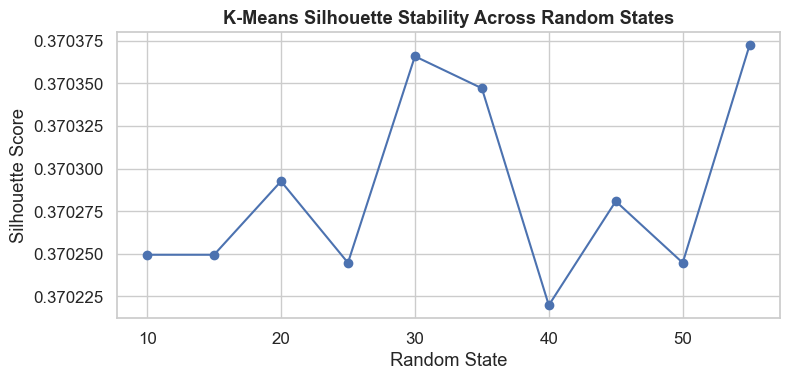

 METHOD JUSTIFICATION

K-Means dipilih sebagai satu-satunya metode clustering karena:
1. Memberikan segmentasi yang stabil terhadap inisialisasi centroid.
2. Menghasilkan jumlah cluster yang jelas dan dapat diinterpretasikan secara bisnis.
3. Cocok untuk data RFM retail yang bersifat kontinyu dan saling overlap.
4. Mendukung kebutuhan utama sistem PROMIND: segmentasi customer untuk strategi pemasaran.

 K-Means validation completed successfully


In [18]:
# K-MEANS ROBUSTNESS & METHOD JUSTIFICATION
# Primary Clustering Method Validation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans_final = KMeans(
    n_clusters=OPTIMAL_K,
    random_state=42,
    n_init=10
)

kmeans_labels = kmeans_final.fit_predict(rfm_scaled_df)

silhouette_final = silhouette_score(rfm_scaled_df, kmeans_labels)
inertia_final = kmeans_final.inertia_

print(" FINAL K-MEANS METRICS")
print(f"Number of clusters : {OPTIMAL_K}")
print(f"Silhouette Score   : {silhouette_final:.4f}")
print(f"Inertia            : {inertia_final:.2f}")

RANDOM_STATES = range(10, 60, 5)

robustness_results = []

for seed in RANDOM_STATES:
    km = KMeans(
        n_clusters=OPTIMAL_K,
        random_state=seed,
        n_init=10
    )
    labels = km.fit_predict(rfm_scaled_df)

    robustness_results.append({
        "RandomState": seed,
        "SilhouetteScore": silhouette_score(rfm_scaled_df, labels),
        "Inertia": km.inertia_
    })

robustness_df = pd.DataFrame(robustness_results)

print("\n K-MEANS ROBUSTNESS CHECK")
display(robustness_df.round(4))

sil_mean = robustness_df["SilhouetteScore"].mean()
sil_std  = robustness_df["SilhouetteScore"].std()
sil_cv   = sil_std / sil_mean

print("\n K-MEANS STABILITY SUMMARY")
display(
    pd.DataFrame({
        "Metric": ["Silhouette_Mean", "Silhouette_Std", "Silhouette_CV"],
        "Value": [sil_mean, sil_std, sil_cv]
    }).round(6)
)

if sil_cv < 0.10:
    print(" STABILITY ASSESSMENT: K-Means clustering is STABLE across random states.")
else:
    print(" STABILITY ASSESSMENT: K-Means shows sensitivity to initialization.")

plt.figure(figsize=(8, 4))
plt.plot(
    robustness_df["RandomState"],
    robustness_df["SilhouetteScore"],
    marker="o"
)
plt.title("K-Means Silhouette Stability Across Random States", weight="bold")
plt.xlabel("Random State")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

print(" METHOD JUSTIFICATION")
print("""
K-Means dipilih sebagai satu-satunya metode clustering karena:
1. Memberikan segmentasi yang stabil terhadap inisialisasi centroid.
2. Menghasilkan jumlah cluster yang jelas dan dapat diinterpretasikan secara bisnis.
3. Cocok untuk data RFM retail yang bersifat kontinyu dan saling overlap.
4. Mendukung kebutuhan utama sistem PROMIND: segmentasi customer untuk strategi pemasaran.
""")

print(" K-Means validation completed successfully")

 PCA Explained Variance Ratio


,Explained_Variance
PC1,0.767994
PC2,0.186685


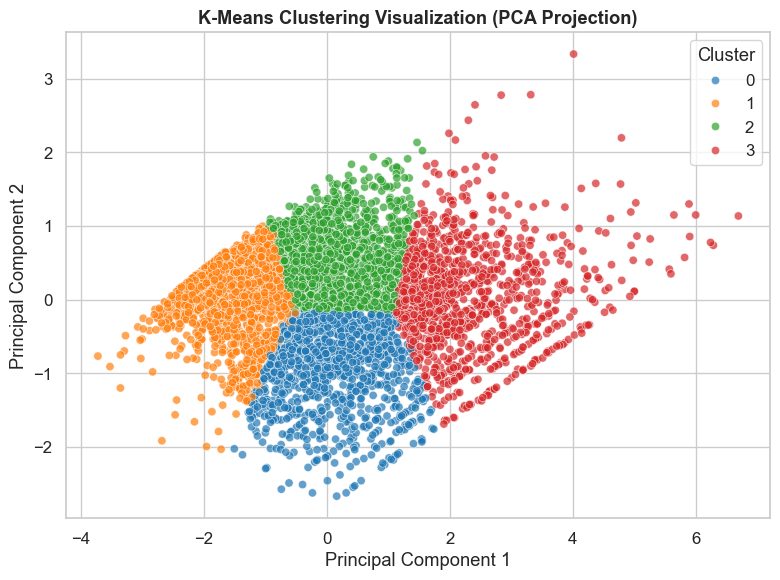

In [19]:
# K-MEANS CLUSTER VISUALIZATION (PCA PROJECTION)

from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PCA ke 2 dimensi (untuk visualisasi)
pca = PCA(n_components=2, random_state=42)
rfm_pca = pca.fit_transform(rfm_scaled_df)

pca_df = pd.DataFrame(
    rfm_pca,
    columns=["PC1", "PC2"],
    index=rfm_scaled_df.index
)

pca_df["Cluster"] = kmeans_labels

print(" PCA Explained Variance Ratio")
display(
    pd.Series(
        pca.explained_variance_ratio_,
        index=["PC1", "PC2"]
    ).to_frame("Explained_Variance")
)

# plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="tab10",
    alpha=0.7
)

plt.title("K-Means Clustering Visualization (PCA Projection)", weight="bold")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.savefig("output/10_pca_cluster_visualization.png", dpi=300, bbox_inches='tight')
plt.show()

,CustomerID,Recency,Frequency,Monetary,Cluster,Segment,SnapshotDate,DataScope,Promo_Response
0,12346.0,326,12,77556.46,3,Champions,2011-12-10 12:49:00,"United Kingdom (cleaned: valid qty & price, no...",NaN
1,12608.0,405,1,415.79,1,At Risk,2011-12-10 12:49:00,"United Kingdom (cleaned: valid qty & price, no...",NaN
2,12745.0,487,2,723.85,1,At Risk,2011-12-10 12:49:00,"United Kingdom (cleaned: valid qty & price, no...",NaN
3,12746.0,541,1,254.55,1,At Risk,2011-12-10 12:49:00,"United Kingdom (cleaned: valid qty & price, no...",NaN
4,12747.0,2,26,9276.54,3,Champions,2011-12-10 12:49:00,"United Kingdom (cleaned: valid qty & price, no...",NaN


 PROMIND — Executive Metrics
Total Customers: 5350

Segment Share (%)


,Customers,Share(%)
Segment,,
At Risk,1831,34.22
Loyal Customers,1320,24.67
Potential Loyalists,1133,21.18
Champions,1066,19.93



Segment RFM Mean


,Recency,Frequency,Monetary
Segment,,,
Champions,27.18,19.32,10004.54
Loyal Customers,228.07,5.24,1909.93
Potential Loyalists,28.42,3.09,845.12
At Risk,395.32,1.38,316.59


 PROMIND — Marketing Recommendation Matrix


,Goal,PromoStyle,Actions,KPI
Segment,,,,
Champions,Pertahankan & maksimalkan CLV,Eksklusif (bukan diskon besar),VIP loyalty tier + early access produk baru | ...,"Repeat rate, CLV, AOV"
Loyal Customers,Naikkan nilai belanja & frekuensi,Loyalty + bundle,Reward point booster untuk pembelian rutin | C...,"Frequency, AOV"
Potential Loyalists,Konversi jadi loyal,Diskon kecil + rekomendasi,Welcome-back deal ringan + rekomendasi produk ...,"2nd purchase rate, retention"
At Risk,Reaktivasi sebelum churn,Win-back (diskon lebih agresif),Win-back campaign (diskon bertingkat) | Survey...,"Reactivation rate, churn reduction"


 Top 50 Priority Customers (Action List)


,CustomerID,Segment,Recency,Frequency,Monetary,PriorityScore,Promo_Response
5165,18102.0,Champions,1,145,608821.650,52.0,NaN
2427,15311.0,Champions,1,208,116771.160,57.0,NaN
5013,17949.0,Champions,1,118,118628.080,64.0,NaN
5,12748.0,Champions,1,336,56599.390,73.0,NaN
960,13798.0,Champions,1,110,75836.870,73.0,NaN
1742,14606.0,Champions,1,192,30861.060,97.0,NaN
4472,17389.0,Champions,1,61,57224.680,99.5,NaN
939,13777.0,Champions,1,61,56478.420,102.5,NaN
4744,17675.0,Champions,1,70,38259.600,109.0,NaN
4907,17841.0,Champions,2,211,70884.070,144.5,NaN


 Files Exported
output/PROMIND_RFM_Segmentation_20251214_201212.csv
output/PROMIND_PriorityCustomers_Top50_20251214_201212.csv
output/PROMIND_MarketingRecommendations_20251214_201212.csv
 Deployment Blueprint Saved
output/PROMIND_DeploymentBlueprint_20251214_201212.json
PROMIND (Promotion Intelligence) membangun segmentasi pelanggan berbasis RFM (Recency, Frequency,
Monetary) menggunakan dataset transaksi Online Retail II (UK scope). Data dibersihkan dari transaksi
invalid (qty/price <= 0), missing CustomerID, dan difokuskan ke United Kingdom agar konsisten
terhadap pola bisnis utama.  Hasil clustering K-Means menghasilkan 4 segmen utama: At Risk, Loyal
Customers, Potential Loyalists, Champions. Setiap segmen diprofilkan menggunakan nilai rata-rata RFM
untuk menghasilkan interpretasi bisnis dan strategi promosi yang actionable.  Sebagai pelengkap
segmentasi, sistem menambahkan predictive ML (baseline) untuk memprediksi potensi respons promo
(dengan proxy label berbasis perilaku transak

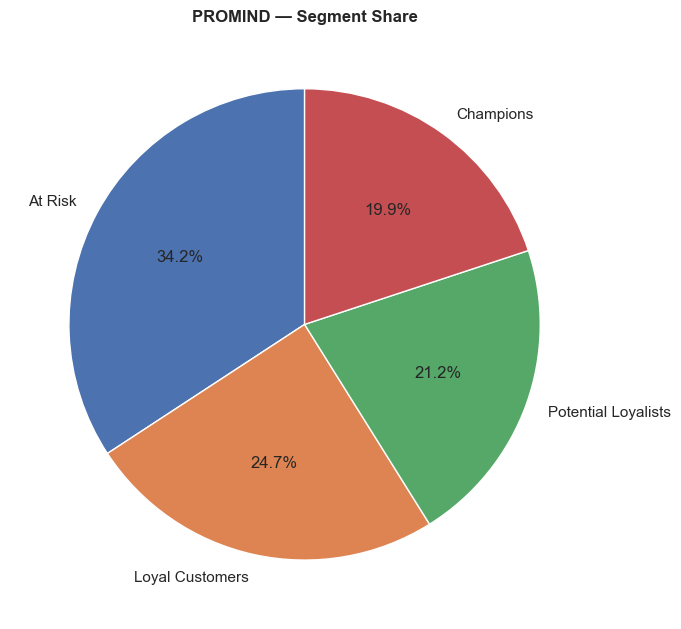

In [20]:
# PROMIND FINALIZATION — Executive Summary + Marketing Actions
# + Export Outputs (CSV) + Simple Deployment Blueprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import textwrap
from datetime import datetime

sns.set(style="whitegrid")

promind_final = rfm_result.copy()

promind_final["SnapshotDate"] = snapshot_date
promind_final["DataScope"] = "United Kingdom (cleaned: valid qty & price, non-missing CustomerID)"

# Jika Cell 15 sudah jalan, tambahkan prediksi respons promo (opsional tapi ideal)
if "Promo_Response" in globals():
    # kalau user sebelumnya bikin rfm_ml, sinkronkan via CustomerID
    try:
        promind_final = promind_final.merge(
            rfm_ml[["CustomerID", "Promo_Response"]],
            on="CustomerID",
            how="left"
        )
    except Exception:
        pass

# Fallback kalau belum ada kolom Promo_Response
if "Promo_Response" not in promind_final.columns:
    promind_final["Promo_Response"] = np.nan

display(promind_final.head())

total_customers = promind_final["CustomerID"].nunique()
segment_counts = promind_final["Segment"].value_counts()
segment_share = (segment_counts / total_customers * 100).round(2)

segment_rfm_mean = (
    promind_final
    .groupby("Segment")[["Recency", "Frequency", "Monetary"]]
    .mean()
    .round(2)
    .sort_values("Monetary", ascending=False)
)

print(" PROMIND — Executive Metrics")
print("Total Customers:", total_customers)
print("\nSegment Share (%)")
display(pd.DataFrame({"Customers": segment_counts, "Share(%)": segment_share}))

print("\nSegment RFM Mean")
display(segment_rfm_mean)

recommendation_map = {
    "Champions": {
        "Goal": "Pertahankan & maksimalkan CLV",
        "Actions": [
            "VIP loyalty tier + early access produk baru",
            "Bundling premium + upsell item high-margin",
            "Personalized thank-you & surprise gift"
        ],
        "PromoStyle": "Eksklusif (bukan diskon besar)",
        "KPI": "Repeat rate, CLV, AOV"
    },
    "Loyal Customers": {
        "Goal": "Naikkan nilai belanja & frekuensi",
        "Actions": [
            "Reward point booster untuk pembelian rutin",
            "Cross-sell berdasarkan kategori sering dibeli",
            "Free shipping threshold (dorong AOV)"
        ],
        "PromoStyle": "Loyalty + bundle",
        "KPI": "Frequency, AOV"
    },
    "Potential Loyalists": {
        "Goal": "Konversi jadi loyal",
        "Actions": [
            "Welcome-back deal ringan + rekomendasi produk relevan",
            "Reminder replenishment (produk habis pakai)",
            "Nudge via email/WA dengan personalized picks"
        ],
        "PromoStyle": "Diskon kecil + rekomendasi",
        "KPI": "2nd purchase rate, retention"
    },
    "At Risk": {
        "Goal": "Reaktivasi sebelum churn",
        "Actions": [
            "Win-back campaign (diskon bertingkat)",
            "Survey alasan tidak aktif + voucher kompensasi",
            "Highlight best-sellers / limited restock"
        ],
        "PromoStyle": "Win-back (diskon lebih agresif)",
        "KPI": "Reactivation rate, churn reduction"
    }
}

recommendation_df = pd.DataFrame([
    {
        "Segment": seg,
        "Goal": rec["Goal"],
        "PromoStyle": rec["PromoStyle"],
        "Actions": " | ".join(rec["Actions"]),
        "KPI": rec["KPI"]
    }
    for seg, rec in recommendation_map.items()
]).set_index("Segment")

print(" PROMIND — Marketing Recommendation Matrix")
display(recommendation_df)

priority = promind_final.copy()

priority["Recency_rank"] = priority["Recency"].rank(ascending=True)
priority["Frequency_rank"] = priority["Frequency"].rank(ascending=False)
priority["Monetary_rank"] = priority["Monetary"].rank(ascending=False)

priority["PriorityScore"] = (
    priority["Recency_rank"] +
    priority["Frequency_rank"] +
    priority["Monetary_rank"]
)

priority_top = (
    priority
    .sort_values("PriorityScore")
    .head(50)[["CustomerID", "Segment", "Recency", "Frequency", "Monetary", "PriorityScore", "Promo_Response"]]
)

print(" Top 50 Priority Customers (Action List)")
display(priority_top.head(15))

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

final_csv_path = f"output/PROMIND_RFM_Segmentation_{timestamp}.csv"
priority_csv_path = f"output/PROMIND_PriorityCustomers_Top50_{timestamp}.csv"
rec_csv_path = f"output/PROMIND_MarketingRecommendations_{timestamp}.csv"

promind_final.to_csv(final_csv_path, index=False)
priority_top.to_csv(priority_csv_path, index=False)
recommendation_df.reset_index().to_csv(rec_csv_path, index=False)

print(" Files Exported")
print(final_csv_path)
print(priority_csv_path)
print(rec_csv_path)

deployment_blueprint = {
    "SystemName": "PROMIND Dashboard",
    "Purpose": "Segmentasi customer + prediksi respon promo untuk strategi pemasaran personal",
    "CoreModules": [
        "Data Ingestion (CSV / database)",
        "RFM Pipeline (cleaning + RFM compute)",
        "Clustering (KMeans) + Segment Naming",
        "Predictive ML (RandomForest baseline)",
        "Insights & Recommendation Panel",
        "Export Target List (CSV) for marketing execution"
    ],
    "SuggestedDeploymentOptions": [
        "Streamlit (fast MVP) + GitHub repo",
        "Power BI dashboard using exported CSV",
        "API microservice (FastAPI) for prediction endpoint (optional)"
    ],
    "Monitoring": [
        "Track segment drift per minggu/bulan",
        "Track campaign response rate per segment",
        "Update model jika distribusi RFM berubah signifikan"
    ],
    "Artifacts": [
        final_csv_path,
        priority_csv_path,
        rec_csv_path
    ]
}

blueprint_path = f"output/PROMIND_DeploymentBlueprint_{timestamp}.json"
with open(blueprint_path, "w") as f:
    json.dump(deployment_blueprint, f, indent=2)

print(" Deployment Blueprint Saved")
print(blueprint_path)

summary_text = f"""
PROMIND (Promotion Intelligence) membangun segmentasi pelanggan berbasis RFM (Recency, Frequency, Monetary)
menggunakan dataset transaksi Online Retail II (UK scope). Data dibersihkan dari transaksi invalid (qty/price <= 0),
missing CustomerID, dan difokuskan ke United Kingdom agar konsisten terhadap pola bisnis utama.

Hasil clustering K-Means menghasilkan {promind_final['Segment'].nunique()} segmen utama: {", ".join(segment_counts.index.tolist())}.
Setiap segmen diprofilkan menggunakan nilai rata-rata RFM untuk menghasilkan interpretasi bisnis dan strategi promosi yang actionable.

Sebagai pelengkap segmentasi, sistem menambahkan predictive ML (baseline) untuk memprediksi potensi respons promo
(dengan proxy label berbasis perilaku transaksi). Output akhir menghasilkan:
1) dataset final segmentasi (CSV),
2) daftar prioritas customer untuk campaign (Top-50),
3) matriks rekomendasi promosi per segmen,
yang dapat langsung diintegrasikan ke dashboard (Streamlit/Power BI) untuk eksekusi pemasaran yang lebih efisien.
""".strip()

print(textwrap.fill(summary_text, width=100))

plt.figure(figsize=(7,7))
plt.pie(
    segment_counts.values,
    labels=segment_counts.index,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("PROMIND — Segment Share", weight="bold")
plt.tight_layout()
plt.savefig("output/11_segment_share_pie.png", dpi=300, bbox_inches='tight')
plt.show()

 AMBANG BATAS OUTLIER (TOP 1% MONETARY)
Monetary ≥ £27,199.91

 DISTRIBUSI CUSTOMER TOP 1% MONETARY


,Total_Customer
Is_Top1pct_Monetary,
False,5296
True,54



 PERSENTASE CUSTOMER TOP 1% MONETARY PER CLUSTER


,Top1pct_%
Cluster,
0,0.00
1,0.00
2,0.15
3,4.88



 PERBANDINGAN MEAN VS MEDIAN MONETARY (CEK DAMPAK OUTLIER)


,Mean,Median,Minimum,Maksimum
Cluster,,,,
0,845.12,735.17,43.20,4014.10
1,316.59,271.70,2.95,1680.47
2,1909.93,1468.82,167.42,44534.30
3,10004.54,5023.34,862.42,608821.65



 KONSENTRASI PENDAPATAN
Customer top 1% menyumbang 29.26% dari total revenue


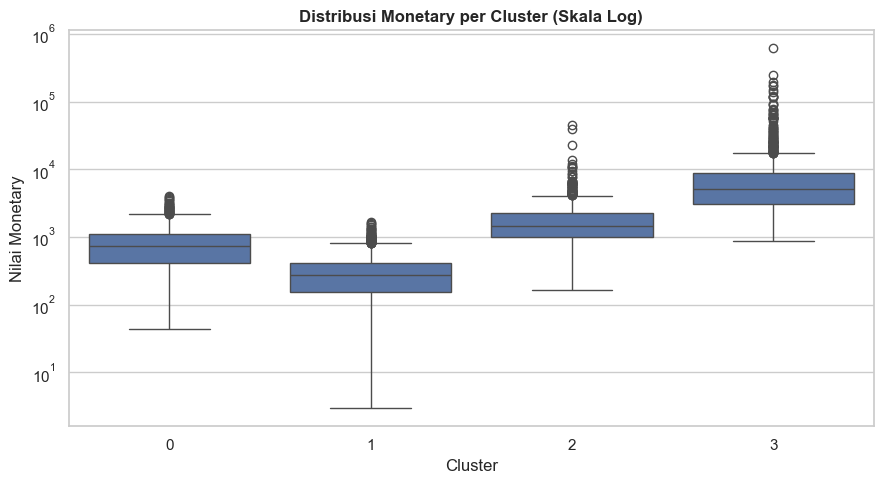

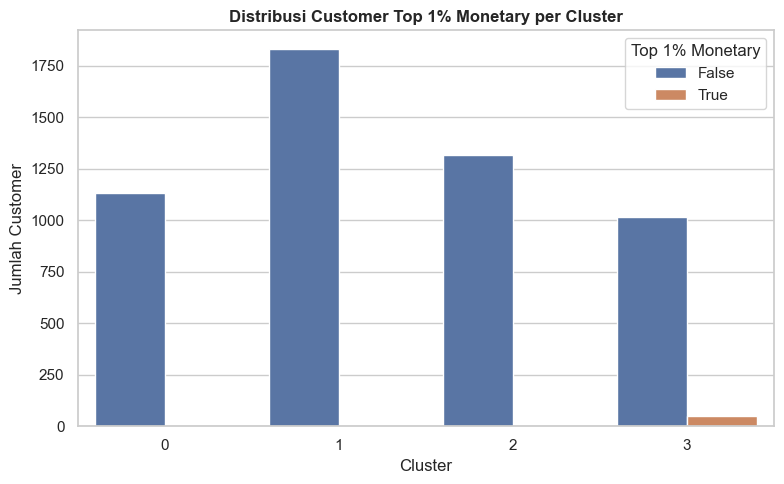

 INTERPRETASI DAMPAK OUTLIER

1. Sebagian kecil customer (top 1%) menyumbang porsi pendapatan yang sangat besar,
   menunjukkan adanya efek whale yang kuat dan umum terjadi pada data retail.

2. Nilai rata-rata (mean) Monetary jauh lebih tinggi dibandingkan median pada
   beberapa cluster, yang menandakan bahwa rata-rata cluster dipengaruhi oleh
   customer bernilai sangat tinggi.

3. Kondisi ini menjelaskan mengapa secara geometris cluster tampak saling
   tumpang tindih dan mengapa nilai silhouette score berada pada tingkat moderat,
   meskipun secara bisnis segmentasi tetap jelas.

4. Outlier tidak dianggap sebagai noise untuk dihapus, melainkan sebagai
   customer strategis bernilai tinggi yang memerlukan strategi retensi khusus.

 Analisis dampak outlier selesai dengan sukses


In [21]:
# ANALISIS DAMPAK OUTLIER (EFEK WHALE PADA MONETARY)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

outlier_df = rfm_result.copy()

# menentukan ambang batas top 1% nilai Monetary
monetary_threshold_99 = outlier_df["Monetary"].quantile(0.99)

outlier_df["Is_Top1pct_Monetary"] = (
    outlier_df["Monetary"] >= monetary_threshold_99
)

print(" AMBANG BATAS OUTLIER (TOP 1% MONETARY)")
print(f"Monetary ≥ £{monetary_threshold_99:,.2f}")

# distribusi customer top 1%
print("\n DISTRIBUSI CUSTOMER TOP 1% MONETARY")
display(
    outlier_df["Is_Top1pct_Monetary"]
    .value_counts()
    .rename("Total_Customer")
    .to_frame()
)

# proporsi top 1% per cluster
print("\n PERSENTASE CUSTOMER TOP 1% MONETARY PER CLUSTER")
display(
    outlier_df
    .groupby("Cluster")["Is_Top1pct_Monetary"]
    .mean()
    .mul(100)
    .round(2)
    .rename("Top1pct_%")
    .to_frame()
)

# perbandingan mean vs median Monetary per cluster
perbandingan_mean_median = (
    outlier_df
    .groupby("Cluster")["Monetary"]
    .agg(
        Mean="mean",
        Median="median",
        Minimum="min",
        Maksimum="max"
    )
    .round(2)
)

print("\n PERBANDINGAN MEAN VS MEDIAN MONETARY (CEK DAMPAK OUTLIER)")
display(perbandingan_mean_median)

# analisis kontribusi revenue
total_revenue = outlier_df["Monetary"].sum()
top1pct_revenue = outlier_df.loc[
    outlier_df["Is_Top1pct_Monetary"],
    "Monetary"
].sum()

print("\n KONSENTRASI PENDAPATAN")
print(
    f"Customer top 1% menyumbang "
    f"{top1pct_revenue / total_revenue * 100:.2f}% dari total revenue"
)

# visualisasi distribusi Monetary
plt.figure(figsize=(9, 5))
sns.boxplot(
    data=outlier_df,
    x="Cluster",
    y="Monetary"
)
plt.yscale("log")
plt.title("Distribusi Monetary per Cluster (Skala Log)", weight="bold")
plt.xlabel("Cluster")
plt.ylabel("Nilai Monetary")
plt.tight_layout()
plt.savefig("output/12_monetary_distribution_outlier.png", dpi=300, bbox_inches='tight')
plt.show()

# visualisasi perbandingan top 1% vs customer lain
plt.figure(figsize=(8, 5))
sns.countplot(
    data=outlier_df,
    x="Cluster",
    hue="Is_Top1pct_Monetary"
)
plt.title("Distribusi Customer Top 1% Monetary per Cluster", weight="bold")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Customer")
plt.legend(title="Top 1% Monetary")
plt.tight_layout()
plt.savefig("output/13_top1pct_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# interpretasi bisnis
print(" INTERPRETASI DAMPAK OUTLIER")
print("""
1. Sebagian kecil customer (top 1%) menyumbang porsi pendapatan yang sangat besar,
   menunjukkan adanya efek whale yang kuat dan umum terjadi pada data retail.

2. Nilai rata-rata (mean) Monetary jauh lebih tinggi dibandingkan median pada
   beberapa cluster, yang menandakan bahwa rata-rata cluster dipengaruhi oleh
   customer bernilai sangat tinggi.

3. Kondisi ini menjelaskan mengapa secara geometris cluster tampak saling
   tumpang tindih dan mengapa nilai silhouette score berada pada tingkat moderat,
   meskipun secara bisnis segmentasi tetap jelas.

4. Outlier tidak dianggap sebagai noise untuk dihapus, melainkan sebagai
   customer strategis bernilai tinggi yang memerlukan strategi retensi khusus.
""")

# pengecekan integritas data
assert outlier_df.shape[0] == rfm_result.shape[0]
print(" Analisis dampak outlier selesai dengan sukses")